# Setup the environment

## Libraries

Installing the required libraries...

In [1]:
!pip install --quiet pytorch-lightning
!pip install --quiet torch
!pip install --quiet tokenizers
!pip install --quiet "transformers>=4.5"
!pip install --quiet "torchmetrics<0.7"

In [2]:
import numpy as np
import random
import torch
import os

def seed_everything(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(55)

## GPU & RAM

Configure the device

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)
  device = torch.device("cuda:0")


Mon Jan 31 15:24:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    31W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## Disk

Let's mount the Google Drive folders

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Evaluation

## Evaluation Dataset

In [6]:
import json

DATASET_PATH = '/content/drive/MyDrive/TFM/dataset/dataset.json'

with open(DATASET_PATH, 'rb') as file:
    dataset = json.load(file)

In [7]:
from transformers.data.processors.squad import SquadV2Processor

processor = SquadV2Processor()
examples = processor.get_dev_examples("/content/drive/MyDrive/TFM/dataset/", filename="dataset.json")
print(f'\nExamples: {len(examples)}')

100%|██████████| 8/8 [00:00<00:00, 71.44it/s]


Examples: 112


## Examples (Question, context and  answers) 

In [8]:
from pprint import pprint

def display_example(example,show_context=True):
  answers_text = [answer['text'] for answer in example.answers]
  print(f'ID: {example.qas_id}\n----------------------------------------')
  print(f"Q: {example.question_text}")
  if show_context:
    print("\nContext:")
    pprint(example.context_text)
  print("\nTrue Answers:")
  for answer in answers_text:
    print(f' - {answer}')

display_example(examples[3])

ID: 117b81a3-236c-45cf-aab3-2793cf11b73a
----------------------------------------
Q: ¿Con que se corresponden los nodos exteriores de un algoritmo de búsqueda?

Context:
('Los algoritmos de búsqueda exploran el espacio de estados generando un árbol '
 'de búsqueda cuya raíz es el estado inicial. Los nodos al final de las ramas '
 'son los nodos hoja, que se corresponden con la lista abierta de estados no '
 'expandidos de un algoritmo. Los nodos interiores se corresponden con la '
 'lista cerrada de estados ya expandidos. La forma en la que el árbol se '
 'genera eligiendo expandir unos estados u otros determina el comportamiento '
 'de algoritmo de búsqueda. Hay que tener en cuenta que, aunque el espacio de '
 'búsqueda se represente como un árbol, pueden existir múltiples caminos desde '
 'el estado inicial a un estado cualquiera. De esta manera, puede darse el '
 'caso de que el mismo estado aparezca en dos nodos del árbol diferentes. Para '
 'evitar desperdiciar trabajo y memoria e

## Prediction

In [9]:
def predict(example, tokenizer, model, threshold=1.0, max_length=512, stride=128):
  inputs = tokenizer(
      example.question_text, 
      example.context_text,  
      max_length                = max_length,
      stride                    = stride,
      add_special_tokens        = True,
      return_overflowing_tokens = True,
      return_offsets_mapping    = True,
      truncation                = 'only_second',
      padding                   = 'max_length',
      return_tensors            = "pt"
  )
  overflow_to_sample_mapping = inputs.pop("overflow_to_sample_mapping")
  offset_mapping = inputs.pop("offset_mapping").tolist()
  input_ids = inputs['input_ids'].to(device)
  attention_mask = inputs['attention_mask'].to(device)
  tokenized_context = [item for sublist in inputs['input_ids'].tolist() for item in sublist]
  sequence_ids = inputs.sequence_ids(0) * len(offset_mapping)
  
  outputs = model(input_ids=input_ids, attention_mask=attention_mask)
  starts = [item for sublist in outputs[0] for item in sublist]
  ends   = [item for sublist in outputs[1] for item in sublist]
  max_score = threshold
  answer = None
  for start, start_value in enumerate(starts):
    if sequence_ids[start]==1:
      for end_idx, end_value in enumerate(ends[start:]):
        end = start + end_idx
        if sequence_ids[end]==1:
          score = start_value + end_value
          if score >= max_score:
            answer = tokenized_context[start:end+1]
            max_score = score
  if answer is None:
    return {'text': "", 'score':None}
  return {
      'text': tokenizer.convert_tokens_to_string(
        tokenizer.convert_ids_to_tokens(answer)
      ),
      'score': max_score
  }

In [10]:
import operator

def best_predictions(example, tokenizer, model, n_predictions=5, threshold=1.0, max_length=512, stride=128):
  predictions = []
  inputs = tokenizer(
      example.question_text, 
      example.context_text,  
      max_length                = max_length,
      stride                    = stride,
      add_special_tokens        = True,
      return_overflowing_tokens = True,
      return_offsets_mapping    = True,
      truncation                = 'only_second',
      padding                   = 'max_length',
      return_tensors            = "pt"
  )
  overflow_to_sample_mapping = inputs.pop("overflow_to_sample_mapping")
  offset_mapping = inputs.pop("offset_mapping").tolist()
  tokenized_context = [item for sublist in inputs['input_ids'].tolist() for item in sublist]
  sequence_ids = inputs.sequence_ids(0) * len(offset_mapping)
  outputs = model(**inputs)
  starts = [item for sublist in outputs[0] for item in sublist]
  ends   = [item for sublist in outputs[1] for item in sublist]
  score_null = starts[0] + ends[0]
  for start, start_value in enumerate(starts):
    if sequence_ids[start]==1:
      sub_ends = ends[start:]
      for end_idx, end_value in enumerate(sub_ends):
        end = start + end_idx
        if sequence_ids[end]==1:
          score = start_value + end_value
          if score > threshold:
            predictions.append({
              'score': score.item(),
              'tokens': tokenized_context[start:end+1],
            })
  predictions = list(reversed(sorted(
        predictions, 
        key=operator.itemgetter("score"),
  )))[:n_predictions]
  for prediction in predictions:
    prediction['text'] = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(prediction['tokens']))
  return predictions
  

## Metrics

In [11]:
def get_gold_answers( example):
    """helper function that retrieves all possible true answers from a squad2.0 example"""
    gold_answers = [answer["text"] for answer in example.answers if answer["text"]]
    # if gold_answers doesn't exist it's because this is a negative example - 
    # the only correct answer is an empty string
    if not gold_answers:
        gold_answers = [""]
        
    return gold_answers

In [12]:
import string
import re

re_articles = re.compile(r"\b(el|la|los|las|unos|unas|un|una)\b", re.UNICODE)

def normalize_text(text):
  # convert the input text to lowercase format
  text = text.lower()
  # remove the punction symbols from the text
  exclude = set(string.punctuation)
  text = "".join(ch for ch in text if ch not in exclude)
  # remove the articles
  text = re.sub(re_articles, " ", text)
  # remove the whitespaces from the text
  return " ".join(text.split())

#### Exact match (EM)

In [13]:
def calculate_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

#### F1

In [14]:
def calculate_f1(prediction, truth, verbose=False):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    if verbose:    
      print(f'\nRespuesta esperada: {truth}')
      print(f'Respuesta predicha: {prediction}')
      print(f'Nº tokens coincidentes: {len(common_tokens)}')
      print(f'Nº tokens en respuesta predicha: {len(pred_tokens)}')
      print(f'Nº tokens en respuesta esperada: {len(truth_tokens)}')
      print(f'precisión: {prec}, recall: {rec}')
      print(f'F1: {2 * (prec * rec) / (prec + rec)}')
    return 2 * (prec * rec) / (prec + rec)

# Models

### Display metrics

In [40]:
# import pandas module for data analysis
import pandas as pd
# import seaborn and matplot library for visualization
import seaborn as sns  
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(16,8)})

def show_em_metrics(data):
  sns.lineplot(x = "threshold", y = "em", data = data, color="blue", label="Todas las preguntas", linestyle="-"  )
  sns.lineplot(x = "threshold", y = "em_ans", data = data, color="green", markers=True, label="Preguntas con respuestas", linestyle="--")
  sns.lineplot(x = "threshold", y = "em_noans", data = data, color="red", label="Preguntas sin respuestas", linestyle="--")
  plt.ylim(0, 1)
  plt.ylabel("Exact Matcj (EM)")
  plt.xlim(-4, 18)
  plt.xlabel("Umbral de respuesta nula")
  plt.legend( fontsize = 'medium')
  plt.show()

def show_f1_metrics(data):
  sns.lineplot(x = "threshold", y = "f1", data = data, color="blue", label="Todas las preguntas", linestyle="-"  )
  sns.lineplot(x = "threshold", y = "f1_ans", data = data, color="green", markers=True, label="Preguntas con respuestas", linestyle="--")
  sns.lineplot(x = "threshold", y = "f1_noans", data = data, color="red", label="Preguntas sin respuestas", linestyle="--")
  plt.ylim(0, 1)
  plt.ylabel("F1")
  plt.xlim(-4, 18)
  plt.xlabel("Umbral de respuesta nula")
  plt.legend( fontsize = 'medium')
  plt.show()

### Calculate model metrics

In [16]:
import datetime

def calculate_metrics(model,tokenizer,thresholds=[-4, -2, 0, 2, 4, 6,  8,  10, 12, 14, 16, 18]):
  cols = ['threshold','em', 'f1', 'em_ans', 'f1_ans', 'em_noans','f1_noans']
  df = pd.DataFrame(columns=cols)
  
  for threshold in thresholds:
    time_start = datetime.datetime.now()
    g1_count=0
    g1_acc_em_score = 0
    g1_acc_f1_score = 0
    
    g2_count=0
    g2_acc_em_score = 0
    g2_acc_f1_score = 0
    
    g3_count=0
    g3_acc_em_score = 0
    g3_acc_f1_score = 0
    print(f'Threshold: {threshold}')
    block_ckpt = datetime.datetime.now()
    for idx, example in enumerate(examples):
      gold_answers = get_gold_answers(example)
      prediction = predict(example,tokenizer,model,threshold=threshold) #,null_threshold=threshold)
      em_score = max((calculate_exact_match(prediction['text'], answer)) for answer in gold_answers)
      g1_acc_em_score+=em_score
      f1_score = max((calculate_f1(prediction['text'], answer,)) for answer in gold_answers)
      g1_acc_f1_score+=f1_score
      g1_count+=1
      if len(example.answers)>0:
        g2_acc_em_score+=em_score
        g2_acc_f1_score+=f1_score      
        g2_count+=1
      else:
        g3_acc_em_score+=em_score
        g3_acc_f1_score+=f1_score
        g3_count+=1
    metrics = {
      'threshold': threshold,
      'em': g1_acc_em_score/g1_count,
      'f1': g1_acc_f1_score/g1_count,
      'em_ans': g2_acc_em_score/g2_count,
      'f1_ans': g2_acc_f1_score/g2_count,
      'em_noans': g3_acc_em_score/g3_count,
      'f1_noans': g3_acc_f1_score/g3_count,
    }
    time_end = datetime.datetime.now()
    time_threshold = time_end - time_start
    df = df.append(metrics, ignore_index=True)
    print(f'Elapsed time: {time_threshold.seconds}')
    torch.cuda.empty_cache() 
  return df



## Pre-trained models

In [ ]:
from transformers import AutoTokenizer, RobertaForQuestionAnswering

### PlanTL-GOB-ES/roberta-base-bne-sqac

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('PlanTL-GOB-ES/roberta-base-bne-sqac',use_fast=True)
model = RobertaForQuestionAnswering.from_pretrained('PlanTL-GOB-ES/roberta-base-bne-sqac')
model.to(device)
df_metrics = calculate_metrics(model, tokenizer)
df_metrics

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/663 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/831k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/497k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/473M [00:00<?, ?B/s]

Threshold: -4
Elapsed time: 124
Threshold: -2
Elapsed time: 124
Threshold: 0
Elapsed time: 125
Threshold: 2
Elapsed time: 126
Threshold: 4
Elapsed time: 127
Threshold: 6
Elapsed time: 128
Threshold: 8
Elapsed time: 129
Threshold: 10
Elapsed time: 130
Threshold: 12
Elapsed time: 129
Threshold: 14
Elapsed time: 130
Threshold: 16
Elapsed time: 131
Threshold: 18
Elapsed time: 132


,threshold,em,f1,em_ans,f1_ans,em_noans,f1_noans
0,-4.0,0.375000,0.454020,0.589286,0.747326,0.160714,0.160714
1,-2.0,0.428571,0.507592,0.589286,0.747326,0.267857,0.267857
2,0.0,0.428571,0.501318,0.589286,0.734778,0.267857,0.267857
3,2.0,0.446429,0.519175,0.589286,0.734778,0.303571,0.303571
4,4.0,0.455357,0.528103,0.589286,0.734778,0.321429,0.321429
5,6.0,0.473214,0.545961,0.589286,0.734778,0.357143,0.357143
6,8.0,0.508929,0.577211,0.589286,0.725850,0.428571,0.428571
7,10.0,0.508929,0.570365,0.571429,0.694302,0.446429,0.446429
8,12.0,0.553571,0.615008,0.571429,0.694302,0.535714,0.535714
9,14.0,0.580357,0.635318,0.482143,0.592065,0.678571,0.678571


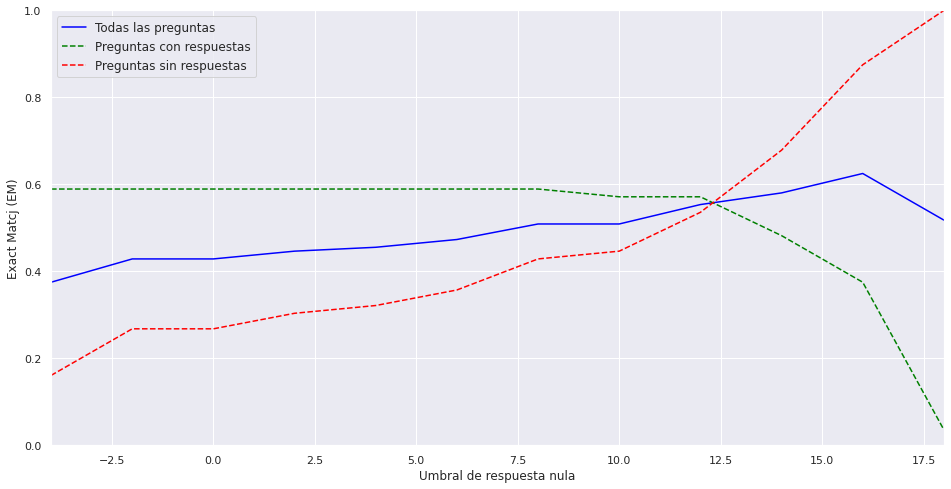

In [ ]:
show_em_metrics(df_metrics)

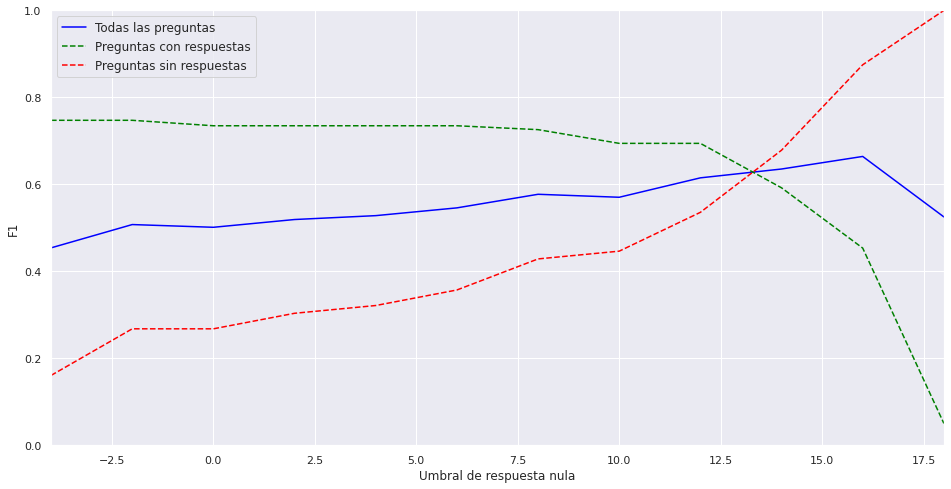

In [ ]:
show_f1_metrics(df_metrics)

### PlanTL-GOB-ES/roberta-large-bne-sqac

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('PlanTL-GOB-ES/roberta-large-bne-sqac')
model = RobertaForQuestionAnswering.from_pretrained('PlanTL-GOB-ES/roberta-large-bne-sqac')
model.to(device)
df_metrics = calculate_metrics(model, tokenizer)
df_metrics

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/838k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/504k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.41M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

Threshold: -4
Elapsed time: 130
Threshold: -2
Elapsed time: 130
Threshold: 0
Elapsed time: 131
Threshold: 2
Elapsed time: 131
Threshold: 4
Elapsed time: 131
Threshold: 6
Elapsed time: 133
Threshold: 8
Elapsed time: 133
Threshold: 10
Elapsed time: 133
Threshold: 12
Elapsed time: 133
Threshold: 14
Elapsed time: 133
Threshold: 16
Elapsed time: 134
Threshold: 18
Elapsed time: 134


,threshold,em,f1,em_ans,f1_ans,em_noans,f1_noans
0,-4.0,0.580357,0.662466,0.660714,0.824932,0.500000,0.500000
1,-2.0,0.580357,0.663657,0.625000,0.791599,0.535714,0.535714
2,0.0,0.607143,0.690442,0.625000,0.791599,0.589286,0.589286
3,2.0,0.616071,0.693419,0.625000,0.779694,0.607143,0.607143
4,4.0,0.607143,0.681757,0.553571,0.702799,0.660714,0.660714
5,6.0,0.625000,0.697063,0.553571,0.697697,0.696429,0.696429
6,8.0,0.633929,0.705991,0.553571,0.697697,0.714286,0.714286
7,10.0,0.651786,0.723848,0.553571,0.697697,0.750000,0.750000
8,12.0,0.642857,0.714920,0.535714,0.679840,0.750000,0.750000
9,14.0,0.678571,0.750634,0.535714,0.679840,0.821429,0.821429


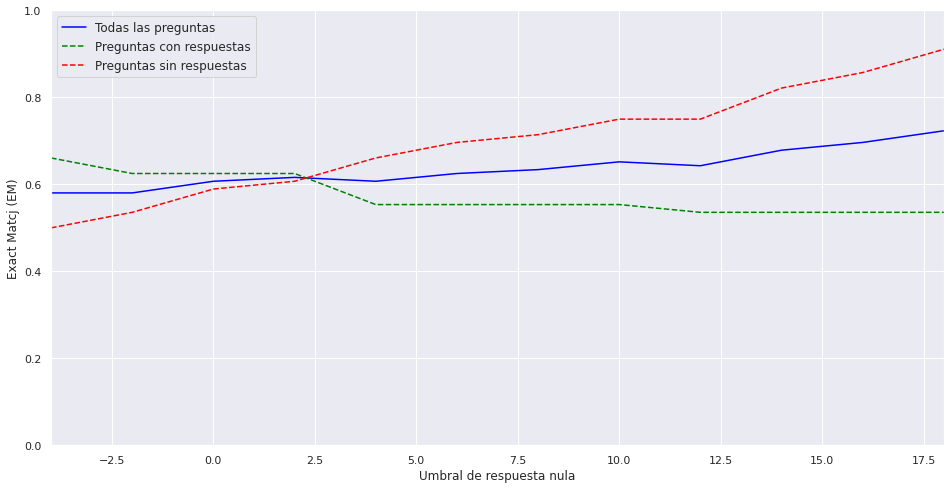

In [ ]:
show_em_metrics(df_metrics)

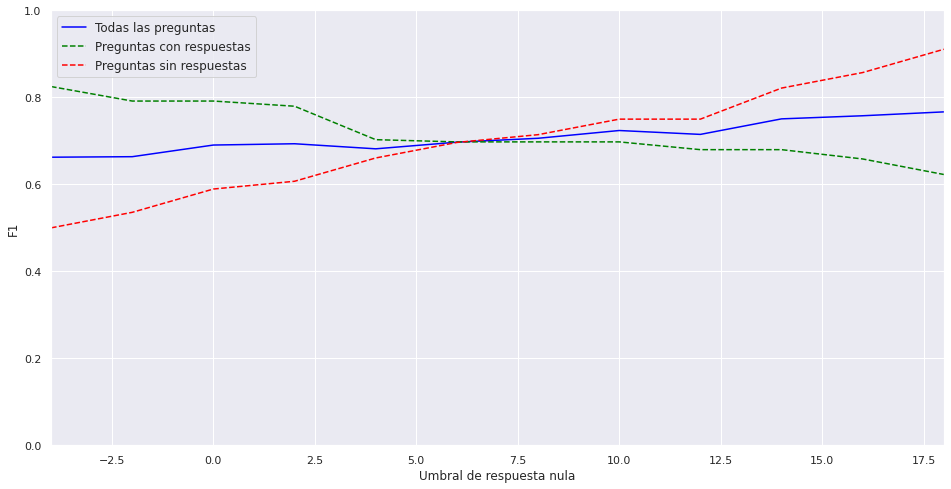

In [ ]:
show_f1_metrics(df_metrics)

### jamarju/roberta-base-bne-squad-2.0-es

In [ ]:
from transformers import AutoTokenizer, RobertaForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained('jamarju/roberta-base-bne-squad-2.0-es', use_fast=True)
model = RobertaForQuestionAnswering.from_pretrained('jamarju/roberta-base-bne-squad-2.0-es')
model.to(device)
df_metrics = calculate_metrics(model, tokenizer)
df_metrics

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/831k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/497k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/473M [00:00<?, ?B/s]

Threshold: -4
Elapsed time: 126
Threshold: -2
Elapsed time: 126
Threshold: 0
Elapsed time: 128
Threshold: 2
Elapsed time: 129
Threshold: 4
Elapsed time: 130
Threshold: 6
Elapsed time: 130
Threshold: 8
Elapsed time: 131
Threshold: 10
Elapsed time: 131
Threshold: 12
Elapsed time: 131
Threshold: 14
Elapsed time: 132
Threshold: 16
Elapsed time: 132
Threshold: 18
Elapsed time: 133


,threshold,em,f1,em_ans,f1_ans,em_noans,f1_noans
0,-4.0,0.589286,0.690719,0.589286,0.792153,0.589286,0.589286
1,-2.0,0.625000,0.721077,0.589286,0.781439,0.660714,0.660714
2,0.0,0.678571,0.774648,0.589286,0.781439,0.767857,0.767857
3,2.0,0.705357,0.801434,0.589286,0.781439,0.821429,0.821429
4,4.0,0.723214,0.819291,0.589286,0.781439,0.857143,0.857143
5,6.0,0.714286,0.805417,0.553571,0.735835,0.875000,0.875000
6,8.0,0.705357,0.778001,0.517857,0.663145,0.892857,0.892857
7,10.0,0.714286,0.783954,0.482143,0.621479,0.946429,0.946429
8,12.0,0.660714,0.694547,0.339286,0.406951,0.982143,0.982143
9,14.0,0.571429,0.593956,0.142857,0.187912,1.000000,1.000000


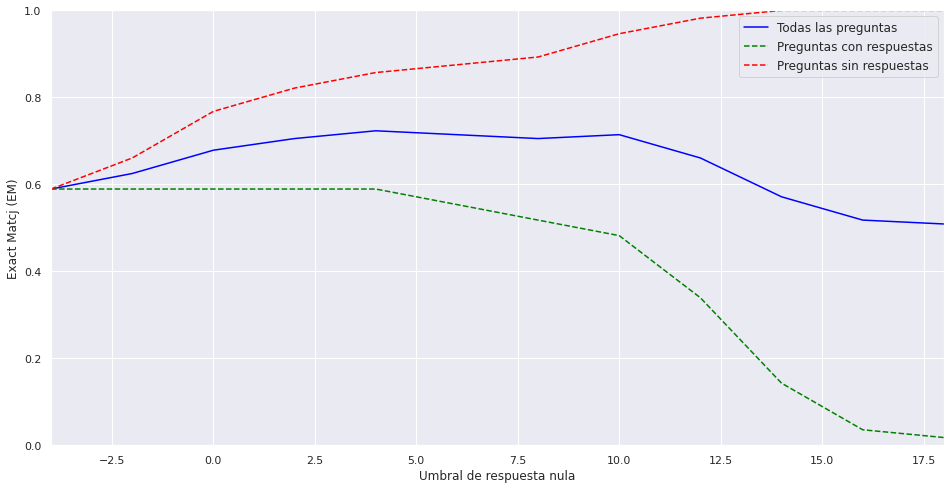

In [ ]:
show_em_metrics(df_metrics)

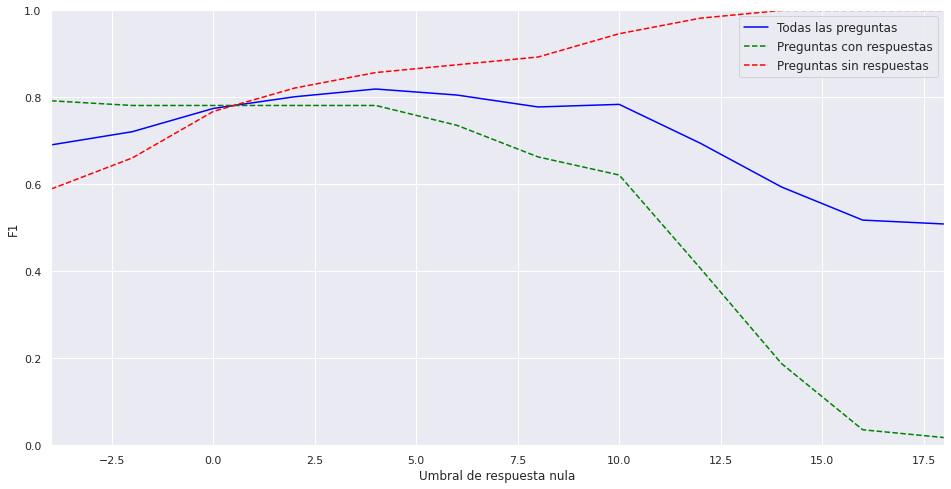

In [ ]:
show_f1_metrics(df_metrics)

### jamarju/roberta-large-bne-squad-2.0-es

In [ ]:
from transformers import AutoTokenizer, RobertaForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained('jamarju/roberta-large-bne-squad-2.0-es')
model = RobertaForQuestionAnswering.from_pretrained('jamarju/roberta-large-bne-squad-2.0-es')

model.to(device)
df_metrics = calculate_metrics(model, tokenizer)
df_metrics

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/838k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/504k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.41M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/736 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

Threshold: -4
Elapsed time: 128
Threshold: -2
Elapsed time: 130
Threshold: 0
Elapsed time: 131
Threshold: 2
Elapsed time: 133
Threshold: 4
Elapsed time: 134
Threshold: 6
Elapsed time: 134
Threshold: 8
Elapsed time: 134
Threshold: 10
Elapsed time: 135
Threshold: 12
Elapsed time: 136
Threshold: 14
Elapsed time: 136
Threshold: 16
Elapsed time: 137
Threshold: 18
Elapsed time: 136


,threshold,em,f1,em_ans,f1_ans,em_noans,f1_noans
0,-4.0,0.392857,0.533644,0.517857,0.799430,0.267857,0.267857
1,-2.0,0.508929,0.649715,0.517857,0.799430,0.500000,0.500000
2,0.0,0.571429,0.704451,0.500000,0.766045,0.642857,0.642857
3,2.0,0.651786,0.781291,0.500000,0.759011,0.803571,0.803571
4,4.0,0.660714,0.790220,0.428571,0.687582,0.892857,0.892857
5,6.0,0.660714,0.790220,0.428571,0.687582,0.892857,0.892857
6,8.0,0.660714,0.766159,0.392857,0.603748,0.928571,0.928571
7,10.0,0.660714,0.755163,0.375000,0.563898,0.946429,0.946429
8,12.0,0.589286,0.641094,0.232143,0.335759,0.946429,0.946429
9,14.0,0.553571,0.570473,0.107143,0.140946,1.000000,1.000000


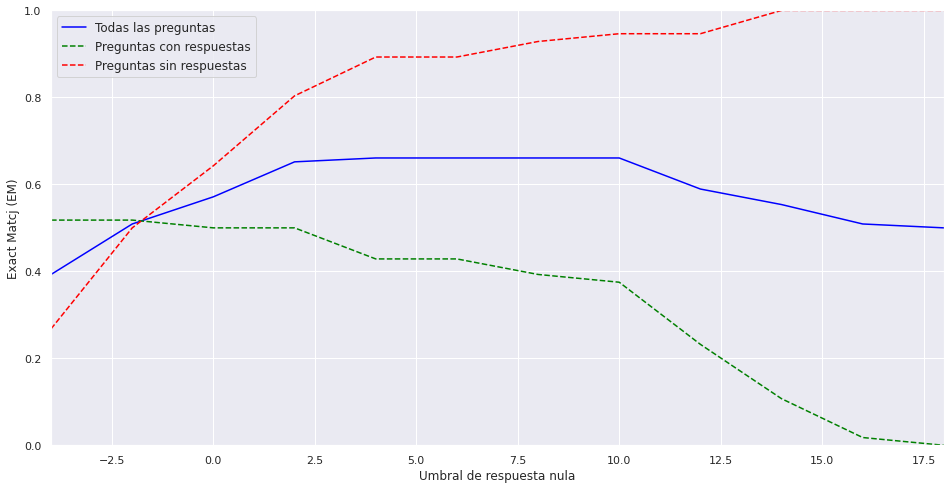

In [ ]:
show_em_metrics(df_metrics)

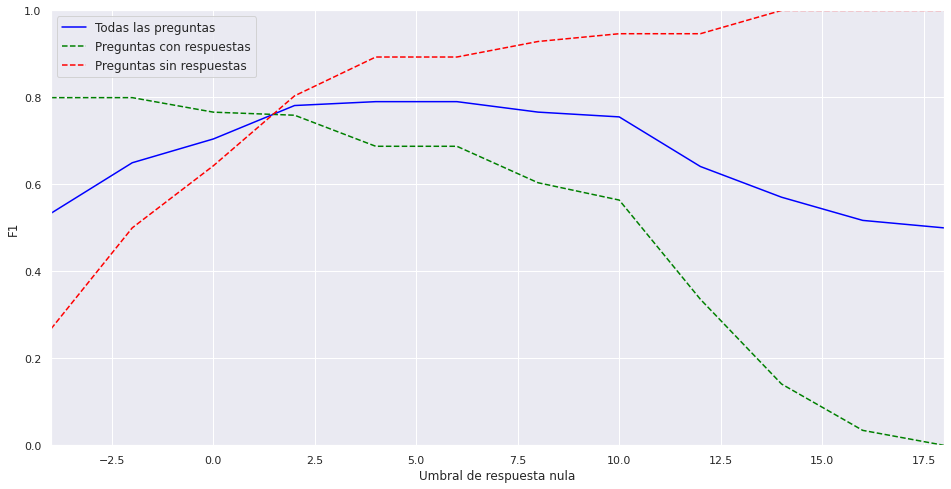

In [ ]:
show_f1_metrics(df_metrics)

### mrm8488/longformer-base-4096-finetuned-squadv2

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("mrm8488/longformer-base-4096-finetuned-squadv2")
model = AutoModelForQuestionAnswering.from_pretrained("mrm8488/longformer-base-4096-finetuned-squadv2")

model.to(device)
df_metrics = calculate_metrics(model, tokenizer)
df_metrics

Threshold: -4
Elapsed time: 643
Threshold: -2
Elapsed time: 646
Threshold: 0
Elapsed time: 656
Threshold: 2
Elapsed time: 662
Threshold: 4
Elapsed time: 666
Threshold: 6


KeyboardInterrupt: ignored

In [ ]:
show_em_metrics(df_metrics)

In [ ]:
show_f1_metrics(df_metrics)

### mrm8488/longformer-base-4096-spanish-finetuned-squad

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("mrm8488/longformer-base-4096-spanish-finetuned-squad")

model = AutoModelForQuestionAnswering.from_pretrained("mrm8488/longformer-base-4096-spanish-finetuned-squad")
model.to(device)
df_metrics = calculate_metrics(model, tokenizer)
df_metrics

Downloading:   0%|          | 0.00/348 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/835k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/882 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/484M [00:00<?, ?B/s]

Threshold: -4
Elapsed time: 128
Threshold: -2
Elapsed time: 128
Threshold: 0
Elapsed time: 128
Threshold: 2
Elapsed time: 128
Threshold: 4
Elapsed time: 128
Threshold: 6
Elapsed time: 129
Threshold: 8
Elapsed time: 130
Threshold: 10
Elapsed time: 129
Threshold: 12
Elapsed time: 129
Threshold: 14
Elapsed time: 129
Threshold: 16
Elapsed time: 130
Threshold: 18
Elapsed time: 130


,threshold,em,f1,em_ans,f1_ans,em_noans,f1_noans
0,-4.0,0.482143,0.544402,0.232143,0.356661,0.732143,0.732143
1,-2.0,0.482143,0.538790,0.232143,0.345437,0.732143,0.732143
2,0.0,0.500000,0.556647,0.214286,0.327580,0.785714,0.785714
3,2.0,0.517857,0.564087,0.214286,0.306746,0.821429,0.821429
4,4.0,0.526786,0.564899,0.214286,0.290512,0.839286,0.839286
5,6.0,0.580357,0.618470,0.214286,0.290512,0.946429,0.946429
6,8.0,0.580357,0.602981,0.214286,0.259533,0.946429,0.946429
7,10.0,0.580357,0.602981,0.214286,0.259533,0.946429,0.946429
8,12.0,0.580357,0.598695,0.214286,0.250962,0.946429,0.946429
9,14.0,0.580357,0.599588,0.196429,0.234890,0.964286,0.964286


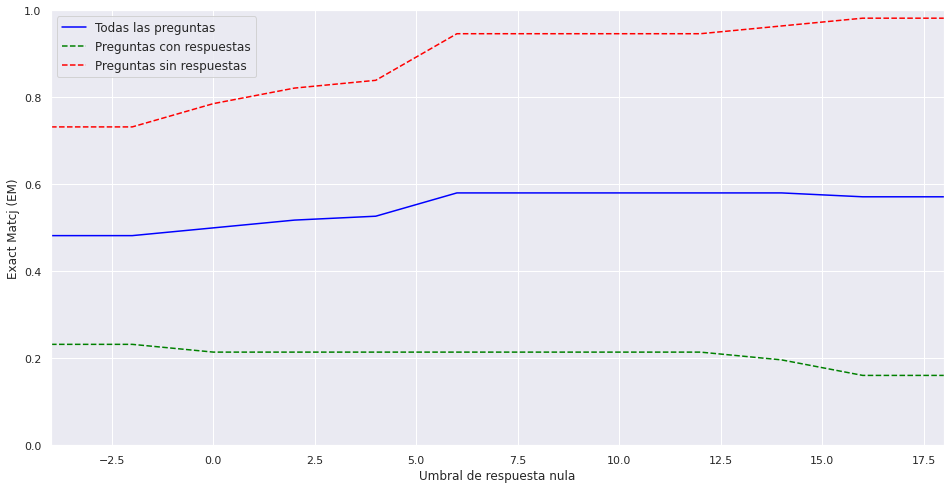

In [ ]:
show_em_metrics(df_metrics)

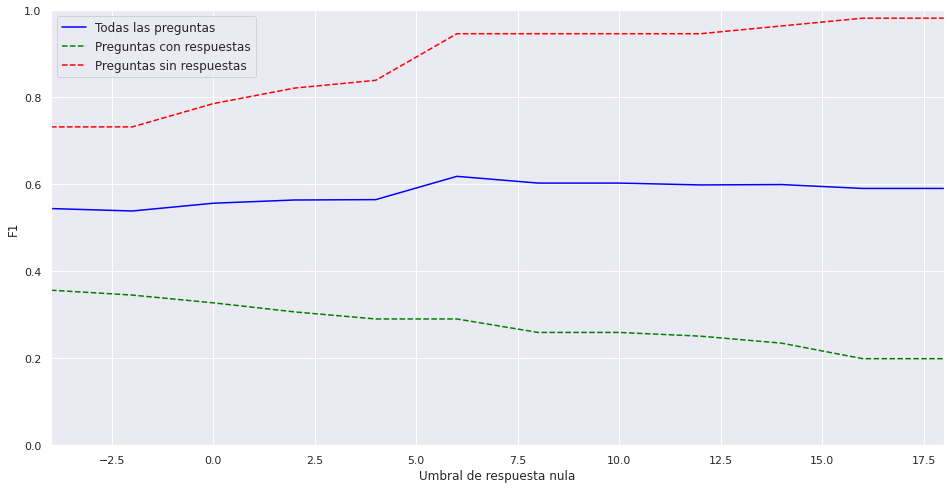

In [ ]:
show_f1_metrics(df_metrics)

### mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es")

model = AutoModelForQuestionAnswering.from_pretrained("mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es")

model.to(device)
df_metrics = calculate_metrics(model, tokenizer)
df_metrics

Downloading:   0%|          | 0.00/135 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/465 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/237k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Threshold: -4
Elapsed time: 214
Threshold: -2
Elapsed time: 215
Threshold: 0
Elapsed time: 217
Threshold: 2
Elapsed time: 221
Threshold: 4
Elapsed time: 222
Threshold: 6
Elapsed time: 225
Threshold: 8
Elapsed time: 225
Threshold: 10
Elapsed time: 227
Threshold: 12
Elapsed time: 232
Threshold: 14
Elapsed time: 232
Threshold: 16
Elapsed time: 233
Threshold: 18
Elapsed time: 232


,threshold,em,f1,em_ans,f1_ans,em_noans,f1_noans
0,-4.0,0.080357,0.198847,0.160714,0.397693,0.000000,0.000000
1,-2.0,0.080357,0.198847,0.160714,0.397693,0.000000,0.000000
2,0.0,0.142857,0.261347,0.160714,0.397693,0.125000,0.125000
3,2.0,0.321429,0.416489,0.160714,0.350835,0.482143,0.482143
4,4.0,0.428571,0.511990,0.142857,0.309694,0.714286,0.714286
5,6.0,0.517857,0.585006,0.142857,0.277155,0.892857,0.892857
6,8.0,0.544643,0.596202,0.142857,0.245975,0.946429,0.946429
7,10.0,0.544643,0.571188,0.089286,0.142376,1.000000,1.000000
8,12.0,0.500000,0.500000,0.000000,0.000000,1.000000,1.000000
9,14.0,0.500000,0.500000,0.000000,0.000000,1.000000,1.000000


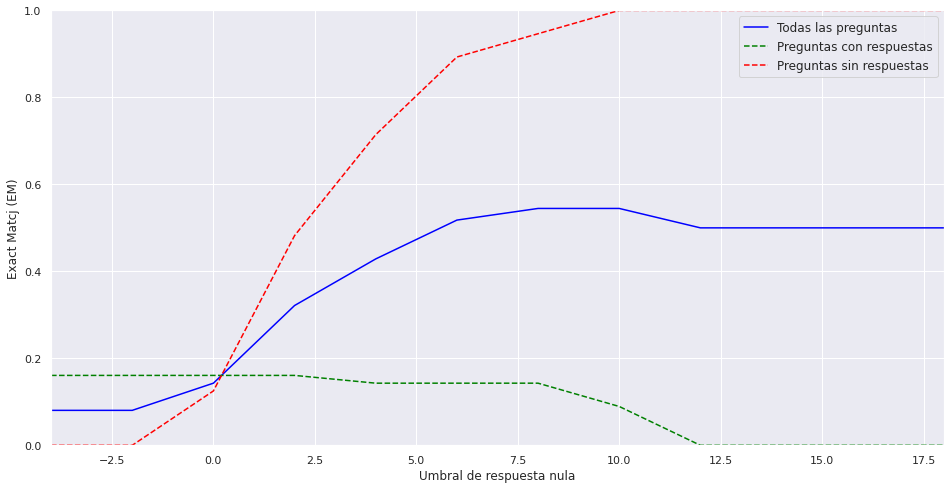

In [ ]:
show_em_metrics(df_metrics)

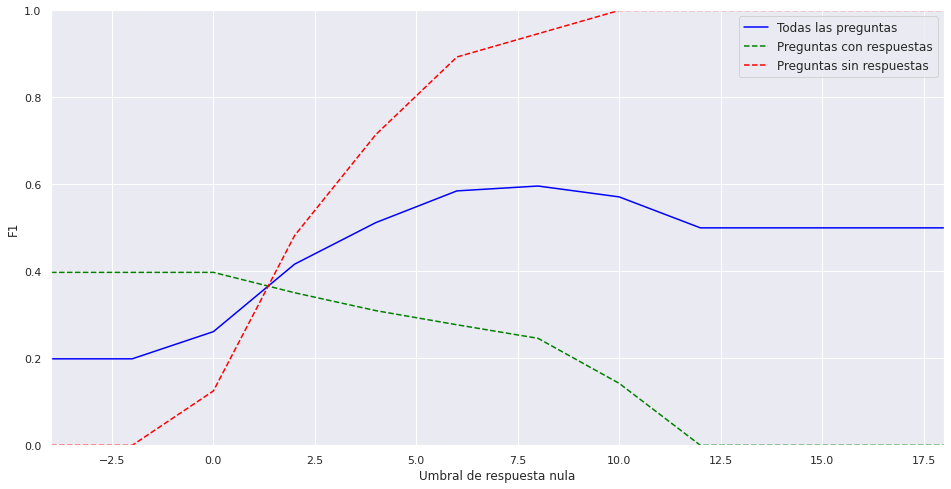

In [ ]:
show_f1_metrics(df_metrics)

### deepset/roberta-base-squad2

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("deepset/roberta-base-squad2")
model = AutoModelForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2")
model.to(device)
df_metrics = calculate_metrics(model, tokenizer)
df_metrics

Threshold: -4
Elapsed time: 638
Threshold: -2
Elapsed time: 645
Threshold: 0
Elapsed time: 651
Threshold: 2
Elapsed time: 661
Threshold: 4
Elapsed time: 669
Threshold: 6
Elapsed time: 674
Threshold: 8
Elapsed time: 679
Threshold: 10
Elapsed time: 678
Threshold: 12
Elapsed time: 682
Threshold: 14
Elapsed time: 682
Threshold: 16
Elapsed time: 682
Threshold: 18
Elapsed time: 683


,threshold,em,f1,em_ans,f1_ans,em_noans,f1_noans
0,-4.0,0.401786,0.499430,0.482143,0.677431,0.321429,0.321429
1,-2.0,0.446429,0.539608,0.482143,0.668502,0.410714,0.410714
2,0.0,0.526786,0.615095,0.446429,0.623047,0.607143,0.607143
3,2.0,0.580357,0.641068,0.339286,0.460708,0.821429,0.821429
4,4.0,0.616071,0.634074,0.339286,0.375291,0.892857,0.892857
5,6.0,0.625000,0.634615,0.285714,0.304945,0.964286,0.964286
6,8.0,0.616071,0.625687,0.250000,0.269231,0.982143,0.982143
7,10.0,0.607143,0.607143,0.214286,0.214286,1.000000,1.000000
8,12.0,0.508929,0.508929,0.017857,0.017857,1.000000,1.000000
9,14.0,0.500000,0.500000,0.000000,0.000000,1.000000,1.000000


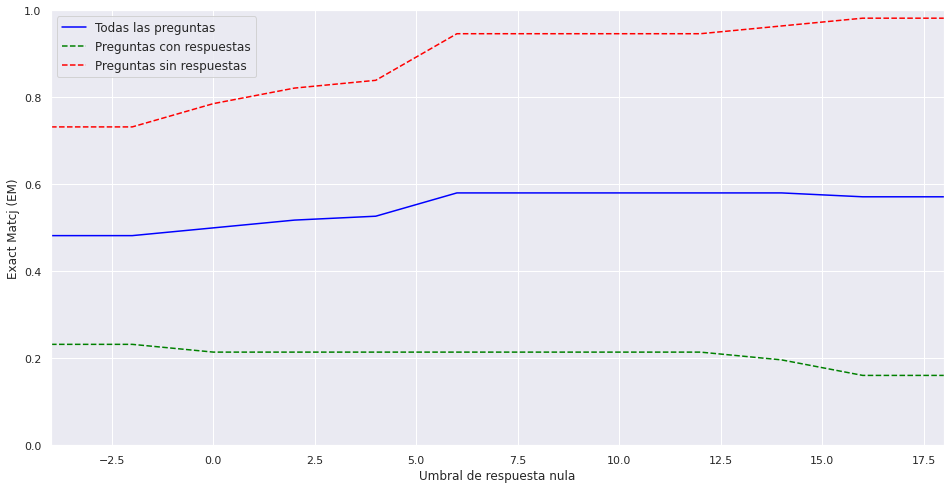

In [ ]:
show_em_metrics(df_metrics)

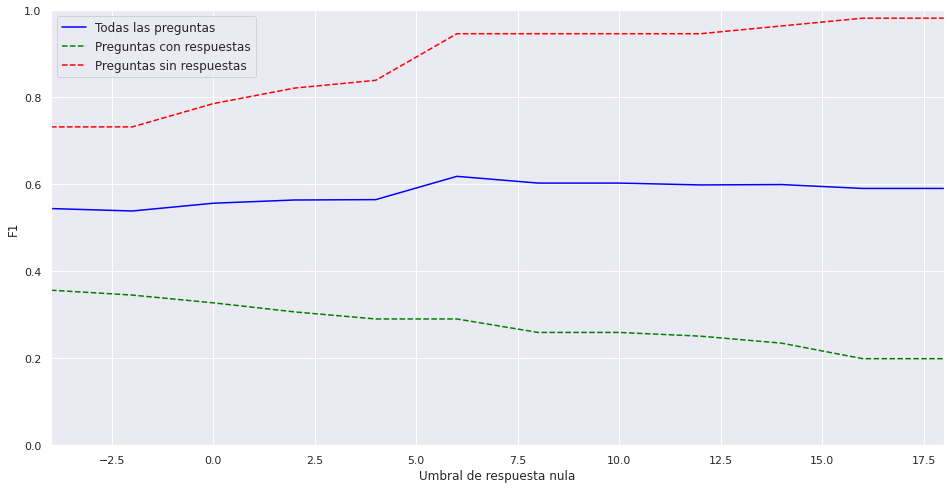

In [ ]:
show_f1_metrics(df_metrics)

### MarcBrun/ixambert-finetuned-squad

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("MarcBrun/ixambert-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("MarcBrun/ixambert-finetuned-squad")
model.to(device)
df_metrics = calculate_metrics(model, tokenizer)
df_metrics

Downloading:   0%|          | 0.00/355 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/914k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/649 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/675M [00:00<?, ?B/s]

Threshold: -4
Elapsed time: 118
Threshold: -2
Elapsed time: 120
Threshold: 0
Elapsed time: 121
Threshold: 2
Elapsed time: 121
Threshold: 4
Elapsed time: 124
Threshold: 6
Elapsed time: 124
Threshold: 8
Elapsed time: 124
Threshold: 10
Elapsed time: 124
Threshold: 12
Elapsed time: 124
Threshold: 14
Elapsed time: 125
Threshold: 16
Elapsed time: 125
Threshold: 18
Elapsed time: 125


,threshold,em,f1,em_ans,f1_ans,em_noans,f1_noans
0,-4.0,0.473214,0.567432,0.482143,0.670579,0.464286,0.464286
1,-2.0,0.562500,0.638592,0.464286,0.616471,0.660714,0.660714
2,0.0,0.607143,0.683235,0.464286,0.616471,0.750000,0.750000
3,2.0,0.598214,0.669307,0.446429,0.588615,0.750000,0.750000
4,4.0,0.607143,0.665034,0.392857,0.508640,0.821429,0.821429
5,6.0,0.616071,0.672177,0.321429,0.433640,0.910714,0.910714
6,8.0,0.607143,0.663249,0.285714,0.397926,0.928571,0.928571
7,10.0,0.598214,0.655213,0.250000,0.363997,0.946429,0.946429
8,12.0,0.607143,0.664142,0.214286,0.328283,1.000000,1.000000
9,14.0,0.589286,0.630540,0.178571,0.261080,1.000000,1.000000


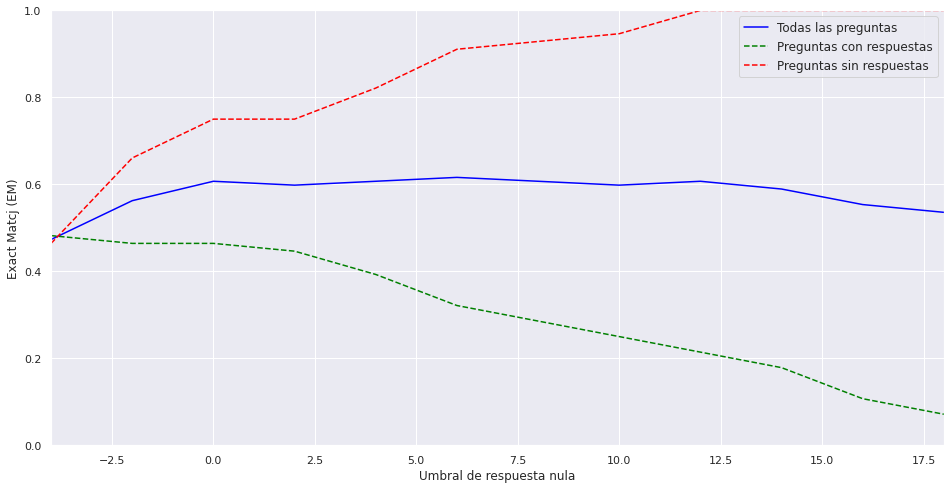

In [ ]:
show_em_metrics(df_metrics)

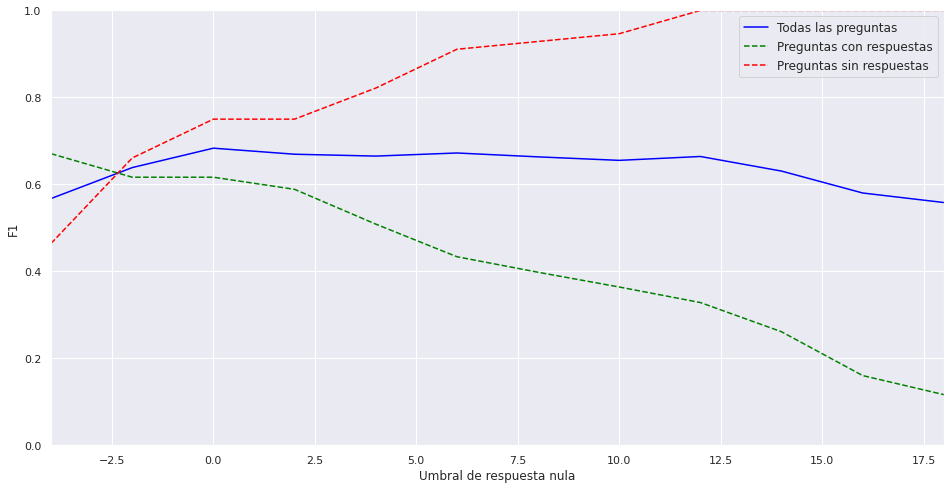

In [ ]:
show_f1_metrics(df_metrics)

### nlp-en-es/bertin-large-finetuned-sqac

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("nlp-en-es/bertin-large-finetuned-sqac")
model = AutoModelForQuestionAnswering.from_pretrained("nlp-en-es/bertin-large-finetuned-sqac")
model.to(device)
df_metrics = calculate_metrics(model, tokenizer)
df_metrics

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/827k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/493k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/721 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/473M [00:00<?, ?B/s]

Threshold: -4
Elapsed time: 124
Threshold: -2
Elapsed time: 124
Threshold: 0
Elapsed time: 126
Threshold: 2
Elapsed time: 126
Threshold: 4
Elapsed time: 127
Threshold: 6
Elapsed time: 128
Threshold: 8
Elapsed time: 128
Threshold: 10
Elapsed time: 128
Threshold: 12
Elapsed time: 128
Threshold: 14
Elapsed time: 128
Threshold: 16
Elapsed time: 128
Threshold: 18
Elapsed time: 129


,threshold,em,f1,em_ans,f1_ans,em_noans,f1_noans
0,-4.0,0.464286,0.554824,0.446429,0.627505,0.482143,0.482143
1,-2.0,0.500000,0.588111,0.446429,0.622651,0.553571,0.553571
2,0.0,0.508929,0.595416,0.428571,0.601547,0.589286,0.589286
3,2.0,0.544643,0.626238,0.428571,0.591761,0.660714,0.660714
4,4.0,0.607143,0.678881,0.428571,0.572048,0.785714,0.785714
5,6.0,0.633929,0.693337,0.392857,0.511674,0.875000,0.875000
6,8.0,0.633929,0.684664,0.357143,0.458613,0.910714,0.910714
7,10.0,0.625000,0.656177,0.339286,0.401640,0.910714,0.910714
8,12.0,0.607143,0.638320,0.285714,0.348069,0.928571,0.928571
9,14.0,0.589286,0.620463,0.214286,0.276640,0.964286,0.964286


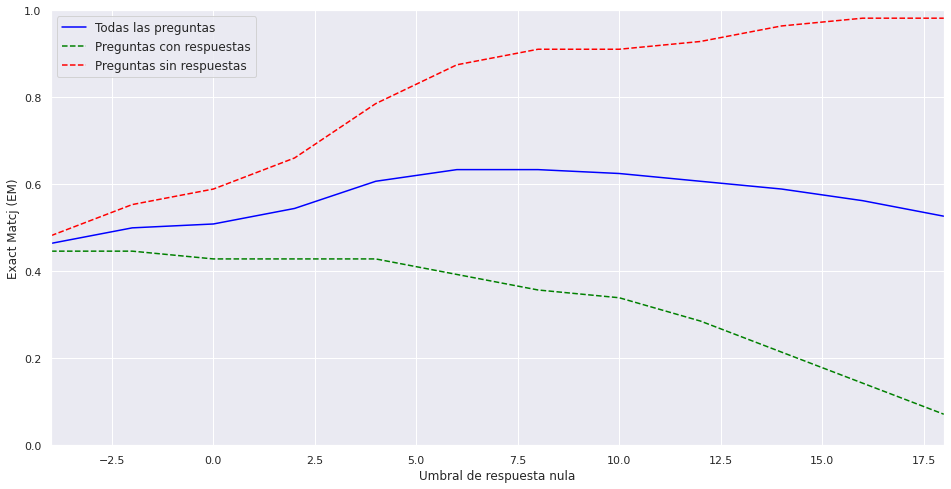

In [ ]:
show_em_metrics(df_metrics)

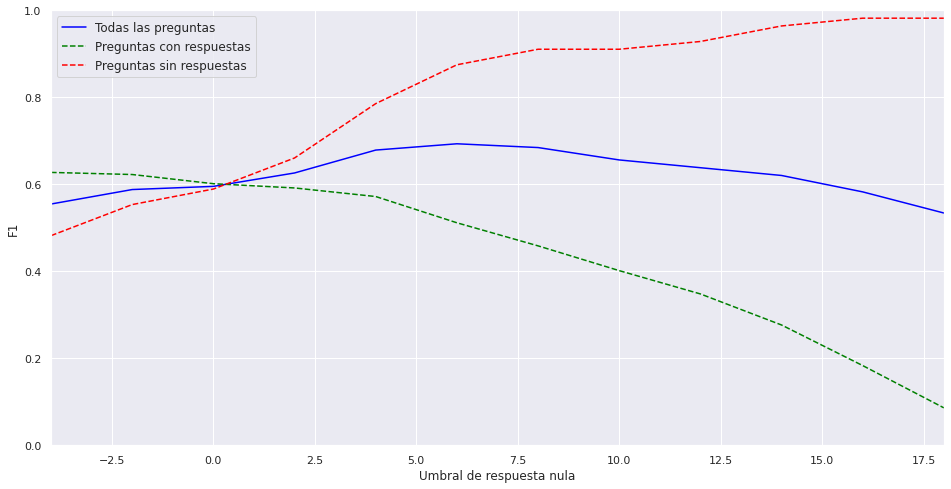

In [ ]:
show_f1_metrics(df_metrics)

### mrm8488/bert-base-spanish-wwm-cased-finetuned-spa-squad2-es

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert-base-spanish-wwm-cased-finetuned-spa-squad2-es")
model = AutoModelForQuestionAnswering.from_pretrained("mrm8488/bert-base-spanish-wwm-cased-finetuned-spa-squad2-es")
model.to(device)
df_metrics = calculate_metrics(model, tokenizer)
df_metrics

Downloading:   0%|          | 0.00/135 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/465 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/237k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Threshold: -4
Elapsed time: 218
Threshold: -2
Elapsed time: 221
Threshold: 0
Elapsed time: 224
Threshold: 2
Elapsed time: 226
Threshold: 4
Elapsed time: 228
Threshold: 6
Elapsed time: 231
Threshold: 8
Elapsed time: 231
Threshold: 10
Elapsed time: 232
Threshold: 12
Elapsed time: 232
Threshold: 14
Elapsed time: 232
Threshold: 16
Elapsed time: 232
Threshold: 18
Elapsed time: 232


,threshold,em,f1,em_ans,f1_ans,em_noans,f1_noans
0,-4.0,0.205357,0.336164,0.232143,0.493757,0.178571,0.178571
1,-2.0,0.401786,0.522729,0.232143,0.474029,0.571429,0.571429
2,0.0,0.464286,0.559046,0.214286,0.403807,0.714286,0.714286
3,2.0,0.517857,0.605475,0.178571,0.353807,0.857143,0.857143
4,4.0,0.544643,0.609966,0.142857,0.273504,0.946429,0.946429
5,6.0,0.553571,0.583114,0.107143,0.166228,1.000000,1.000000
6,8.0,0.526786,0.544721,0.053571,0.089443,1.000000,1.000000
7,10.0,0.508929,0.508929,0.017857,0.017857,1.000000,1.000000
8,12.0,0.500000,0.500000,0.000000,0.000000,1.000000,1.000000
9,14.0,0.500000,0.500000,0.000000,0.000000,1.000000,1.000000


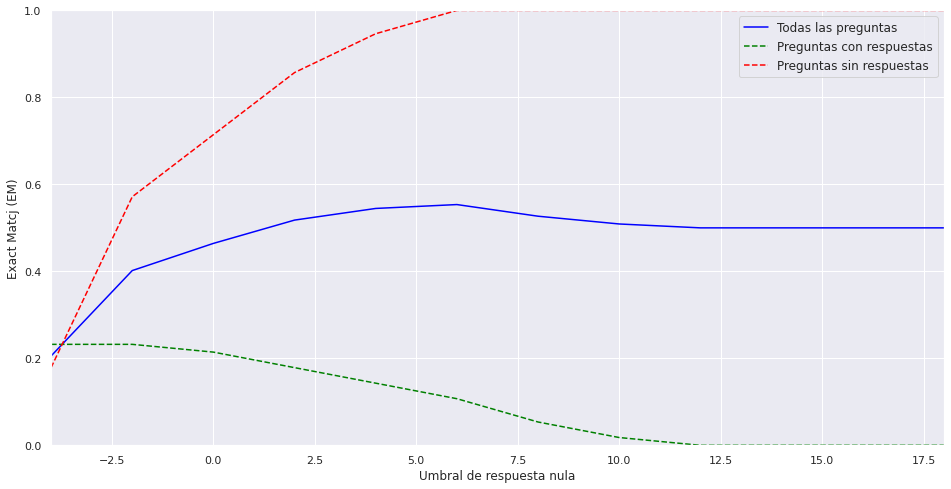

In [ ]:
show_em_metrics(df_metrics)

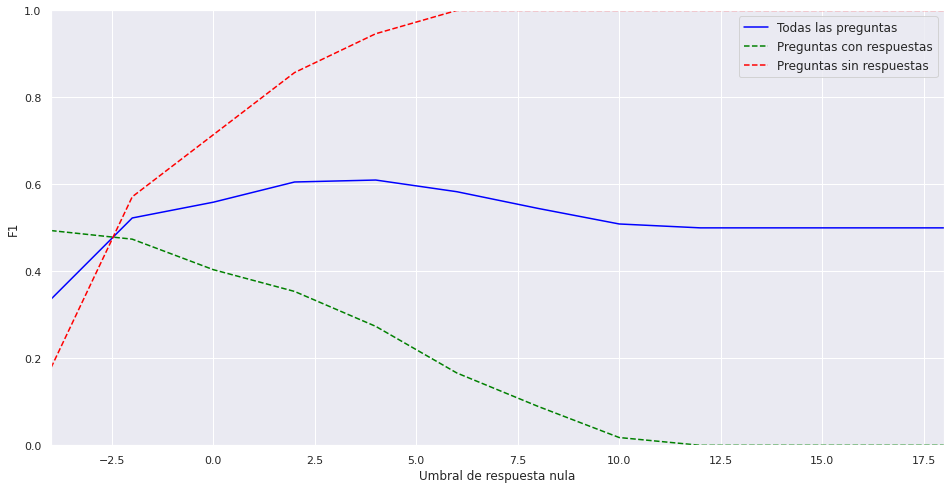

In [ ]:
show_f1_metrics(df_metrics)

## Fine tunning (via script)

In [101]:
!curl -L -O https://raw.githubusercontent.com/huggingface/transformers/b90745c5901809faef3136ed09a689e7d733526c/examples/run_squad.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35374  100 35374    0     0   677k      0 --:--:-- --:--:-- --:--:--  677k


In [107]:
#!/bin/sh
#!export DATA_DIR=/content/squad 
#!export MODEL_DIR=./models
!python run_squad.py  \
    --model_type bert   \
    --model_name_or_path PlanTL-GOB-ES/roberta-base-bne-sqac  \
    --output_dir /content/models/bert/ \
    --data_dir /content/squad   \
    --overwrite_output_dir \
    --overwrite_cache \
    --do_train  \
    --train_file tdataset.json   \
    --version_2_with_negative \
    --do_lower_case  \
    --do_eval   \
    --per_gpu_train_batch_size 2   \
    --learning_rate 3e-5   \
    --num_train_epochs 2.0   \
    --max_seq_length 384   \
    --doc_stride 128   \
    --threads 10   \
    --save_steps 5000 
#--predict_file dev-v2.0.json   \

Traceback (most recent call last):
  File "run_squad.py", line 80, in <module>
    (),
  File "run_squad.py", line 78, in <genexpr>
    for conf in (BertConfig, CamembertConfig, RobertaConfig, XLNetConfig, XLMConfig)
AttributeError: type object 'BertConfig' has no attribute 'pretrained_config_archive_map'


## Fine tunning

### Data preparation

In [17]:
def process_dataset(dataset):

  contexts  = []
  questions = []
  answers   = []

  for data in dataset['data']:
    for paragraph in data['paragraphs']:
      context = paragraph['context']
      for qa in paragraph['qas']:
        question = qa['question']
        for answer in qa['answers']:
          contexts.append(context)
          questions.append(question)
          answers.append(answer)
  return contexts, questions, answers

contexts, questions, answers = process_dataset(dataset)

zipped_lists = list(zip(contexts, questions, answers))
random.shuffle(zipped_lists)
contexts, questions, answers = zip(*zipped_lists)

print(f'Total loaded questions {len(questions)}')

Total loaded questions 120


In [18]:
def add_end_index(answers, contexts):
  invalid_indexes = []
  for index,(answer, context) in enumerate(zip(answers, contexts)):
    gold_text = f"{answer['text']}"
    start_idx = answer['answer_start']
    end_idx = start_idx + len(gold_text)
    if context[start_idx:end_idx] == gold_text:
      answer['answer_end'] = end_idx
    else:
      modified = False
      for n in range(3):
        if context[start_idx+n:end_idx+n] == gold_text:
          answer['answer_start'] = start_idx + n
          answer['answer_end'] = end_idx + n
          modified = True
      if not modified: 
        invalid_indexes.append(index)
      print(answer)
  return invalid_indexes

def remove_elements_at(contexts,questions,answers,indexes):
    contexts = list(contexts)
    questions = list(questions)
    answers = list(answers)
    for index in reversed(indexes):
     del contexts[index]
     del questions[index]
     del answers[index]
    return contexts, questions, answers


invalid_indexes = add_end_index(answers, contexts)
contexts, questions, answers = remove_elements_at(contexts, questions, answers, invalid_indexes)

{'text': 'asincrono', 'answer_start': -1}


In [19]:
total_records = len(contexts)
train_len     = int(total_records*.7)
test_len     = int(total_records*.15)
val_len       = total_records - train_len - test_len

# trainning data
train_contexts  = contexts[:train_len]
train_questions = questions[:train_len]
train_answers   = answers[:train_len]
  
# validation data
val_contexts  = contexts[train_len:-test_len]
val_questions = questions[train_len:-test_len]
val_answers   = answers[train_len:-test_len]

# validation data
test_contexts  = contexts[-test_len:]
test_questions = questions[-test_len:]
test_answers   = answers[-test_len:]

print(f'Total questions: {len(contexts)}')
print(f'Questions used to train the model: {len(train_answers)}')
print(f'Questions used to validate the model: {len(val_answers)}')
print(f'Questions used to test the model: {len(test_answers)}')

Total questions: 119
Questions used to train the model: 83
Questions used to validate the model: 19
Questions used to test the model: 17


### Dataset

In [20]:
import torch

class SquadDataset(torch.utils.data.Dataset):
  
  def __init__(self, encodings):
    self.encodings  = encodings

  def __getitem__(self, idx):
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

  def __len__(self):
    return len(self.encodings['input_ids']) 

In [22]:
def prepare_dataset(tokenizer, args, questions, contexts, answers):
  encodings = tokenizer(
      questions, 
      contexts,
      max_length                = 512,
      stride                    = 100,
      add_special_tokens        = True,
      return_overflowing_tokens = True,
      return_offsets_mapping    = True,
      truncation                = 'only_second',
      padding                   = 'max_length',
  )
  for answer, context in zip(answers, contexts):
    gold_text = f"{answer['text']}"
    start_idx = answer['answer_start']
    end_idx = start_idx + len(gold_text)
    if context[start_idx:end_idx] == gold_text:
      answer['answer_end'] = end_idx
    elif context[start_idx - 1:end_idx - 1] == gold_text:
      answer['answer_start'] = start_idx - 1
      answer['answer_end'] = end_idx - 1
    elif context[start_idx - 2:end_idx - 2] == gold_text:
      answer['answer_start'] = start_idx - 2
      answer['answer_end'] = end_idx - 2

  start_positions = []
  end_positions = []
  for i,answer in enumerate(answers):
    start_positions.append(encodings.char_to_token(i, answer['answer_start'], i))
    end_positions.append(encodings.char_to_token(i, answer['answer_end'] - 1, i))
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length
    if end_positions[-1] is None:
      end_positions[-1] = tokenizer.model_max_length
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})
  return SquadDataset(encodings)
  
  

### Model definition

In [23]:
from pathlib import Path

class QAModelConfig(dict):
    # model
    #model_name_or_path = "google/muril-large-cased"
    model_name_or_path = "PlanTL-GOB-ES/roberta-large-bne-sqac"
    accumulate_grad_batches = 2
    dest_dir = Path("./squad-combined")

    # tokenizer
    #tokenizer_name = "google/muril-large-cased"
    tokenizer_name = "PlanTL-GOB-ES/roberta-large-bne-sqac"
    max_seq_length = 256
    doc_stride = 64

    # train
    num_epochs = 8
    train_batch_size = 4
    eval_batch_size = 4

    # optimizer
    learning_rate = 1.5e-5
    weight_decay = 1e-2
    adam_epsilon = 1e-8
    max_grad_norm = 1.0

    # scheduler
    warmup_ratio = 0.1

    # logging
    logging_steps = 1

    # evaluate
    output_dir = 'output'
    seed = 42

In [24]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, SequentialSampler
cfg = QAModelConfig()


train_tokenizer = AutoTokenizer.from_pretrained(cfg.tokenizer_name)

train_dataset = prepare_dataset(train_tokenizer,
  cfg,train_questions,train_contexts,train_answers,
)  
train_sampler = SequentialSampler(train_dataset)
train_dataloader = DataLoader(
  train_dataset,
  sampler=train_sampler,
  batch_size=cfg.train_batch_size, 
  num_workers=4
)

val_dataset =  prepare_dataset(train_tokenizer,
    cfg,val_questions,val_contexts,val_answers,
)
eval_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(
  val_dataset, 
  sampler=eval_sampler,
  batch_size=cfg.eval_batch_size, 
  num_workers=4
)


In [25]:
import torch
import transformers as tfs
import pytorch_lightning as pl
from transformers import get_linear_schedule_with_warmup
from transformers import AdamW, AutoModelForQuestionAnswering


import gc

class QAModel(pl.LightningModule):
  
  def __init__(self, args, train_dataloader_len):
    super(QAModel, self).__init__()
    self.save_hyperparameters()
    self.args = args
    self.train_dataloader_len = train_dataloader_len
    self.learning_rate = args.learning_rate
    self.model = AutoModelForQuestionAnswering.from_pretrained(self.args.model_name_or_path)

  def training_step(self, batch, batch_idx):
    overflow_to_sample_mapping = batch.pop("overflow_to_sample_mapping")
    offset_mapping = batch.pop("offset_mapping").tolist()
    outputs = self(**batch)
    loss = outputs["loss"]
    
    #self.log("train/loss", loss, on_step=True, on_epoch=True)
    return loss

  def forward(self, input_ids, attention_mask, start_positions, end_positions):
    return self.model(
        input_ids = input_ids,
        attention_mask = attention_mask, 
        start_positions = start_positions, 
        end_positions = end_positions
    )
  
  def validation_step(self, batch, batch_idx):
    overflow_to_sample_mapping = batch.pop("overflow_to_sample_mapping")
    offset_mapping = batch.pop("offset_mapping").tolist()
    outputs = self(**batch)
    loss = outputs["loss"]
    #self.log('val/loss', loss, prog_bar=True, on_step=True, logger=True, on_epoch=False)
    start_true = batch['start_positions'].to(device)
    end_true = batch['end_positions'].to(device) 
  
  def test_step(self, batch, batch_idx):
    overflow_to_sample_mapping = batch.pop("overflow_to_sample_mapping")
    offset_mapping = batch.pop("offset_mapping").tolist()
    outputs = self(**batch)
    loss = outputs["loss"]
    #self.log('test/loss', loss, prog_bar=True, on_step=True, logger=True, on_epoch=False)
    return loss 
  
  def on_epoch_end(self):
    torch.cuda.empty_cache()
    gc.collect()

  def configure_optimizers(self):
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in self.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.args.weight_decay,
        },
        {
            "params": [p for n, p in self.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(
      optimizer_grouped_parameters, 
      lr=self.learning_rate,     
      eps=self.args.adam_epsilon,
      correct_bias=True,
    )
    
    self.num_training_steps= self.train_dataloader_len  * self.args.num_epochs
    self.num_warmup_steps= self.num_training_steps * self.args.warmup_ratio

    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps = self.num_warmup_steps, num_training_steps= self.num_training_steps
    )
    return {
        'optimizer': optimizer,
    }

  def save_json(data, path):
    # save as jsonlines
    with open(path, "w") as f:
      for d in data:
        f.write(json.dumps(d) + "\n")

model = QAModel(args=cfg,train_dataloader_len=len(train_dataloader))

### Training

In [28]:
!rm -rf /content/lightning_logs
!rm -rf /content/checkpoints
!rm -rf /content/squad

In [29]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import BaseFinetuning

earlystopping = EarlyStopping(
   monitor='val/loss', patience=5, mode='min'
)

checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  monitor='val/loss',
  save_top_k=1,
  save_last=True,
  save_weights_only=True,
  filename='checkpoint/{epoch:02d}',
  verbose=False,
  mode='min',
)

trainer = pl.Trainer(
  gpus=1,
  max_epochs=cfg.num_epochs,
  callbacks=[checkpoint_callback], #, earlystopping],
  precision=16,
  auto_lr_find=True,
  accumulate_grad_batches=cfg.accumulate_grad_batches,
  val_check_interval=0.1,
  log_every_n_steps=cfg.logging_steps,
)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [30]:
trainer.fit(
  model, 
  train_dataloaders=train_dataloader, 
  val_dataloaders=val_dataloader,        
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name  | Type                        | Params
------------------------------------------------------
0 | model | RobertaForQuestionAnswering | 354 M 
------------------------------------------------------
354 M     Trainable params
0         Non-trainable params
354 M     Total params
708.618   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [121]:
#model.save_json('/content/mymodel.json')
del model, trainer
gc.collect()
torch.cuda.empty_cache()

In [36]:
custom_model = model.model
custom_model.to(device)

RobertaForQuestionAnswering(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50262, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              

In [41]:
df_metrics = calculate_metrics(custom_model,train_tokenizer)

Threshold: -4
Elapsed time: 207
Threshold: -2
Elapsed time: 206
Threshold: 0
Elapsed time: 208
Threshold: 2
Elapsed time: 211
Threshold: 4
Elapsed time: 213
Threshold: 6
Elapsed time: 215
Threshold: 8
Elapsed time: 216
Threshold: 10
Elapsed time: 215
Threshold: 12
Elapsed time: 215
Threshold: 14
Elapsed time: 211
Threshold: 16
Elapsed time: 211
Threshold: 18
Elapsed time: 212


In [44]:
df_metrics

,threshold,em,f1,em_ans,f1_ans,em_noans,f1_noans
0,-4.0,0.580357,0.662466,0.660714,0.824932,0.500000,0.500000
1,-2.0,0.580357,0.663657,0.625000,0.791599,0.535714,0.535714
2,0.0,0.607143,0.690442,0.625000,0.791599,0.589286,0.589286
3,2.0,0.616071,0.693419,0.625000,0.779694,0.607143,0.607143
4,4.0,0.607143,0.681757,0.553571,0.702799,0.660714,0.660714
5,6.0,0.625000,0.697063,0.553571,0.697697,0.696429,0.696429
6,8.0,0.633929,0.705991,0.553571,0.697697,0.714286,0.714286
7,10.0,0.651786,0.723848,0.553571,0.697697,0.750000,0.750000
8,12.0,0.642857,0.714920,0.535714,0.679840,0.750000,0.750000
9,14.0,0.678571,0.750634,0.535714,0.679840,0.821429,0.821429


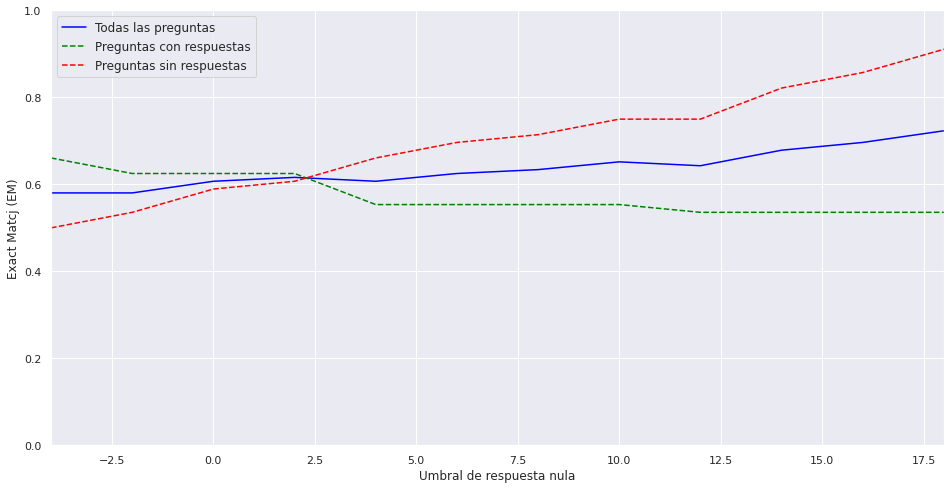

In [42]:
show_em_metrics(df_metrics)

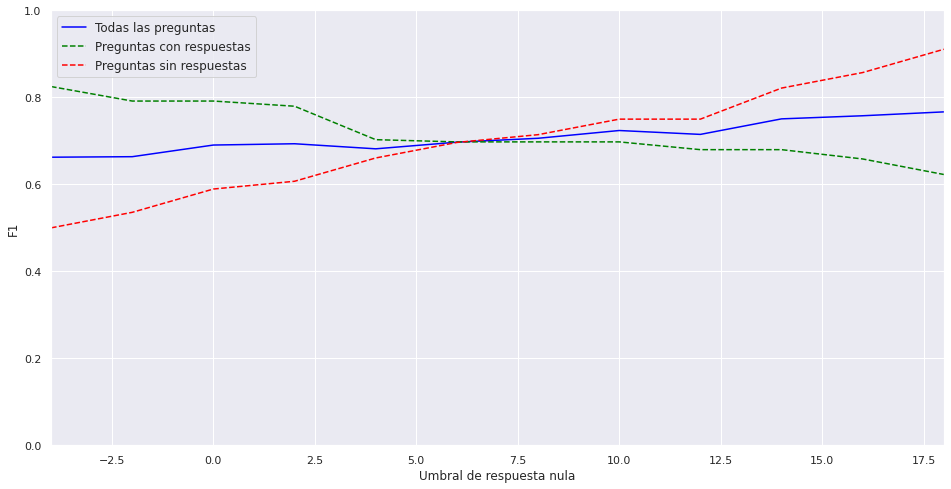

In [43]:
show_f1_metrics(df_metrics)